# Sentiment Analysis on User Reviews

## Setting Up the Environment

In [49]:
!pip install nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.3 MB/s eta 0:00:00a 0:00:01
Using cached click-8.1.7-py3-none-any.whl (97 kB)


In [50]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# plt.style.use('ggplot')

## 

## Load the Data

For now, we are not merging the review dataset because of the size. The files will be processed separately and then merged. There might be some duplicates after that because of how the reviews are separated, these will be handled after as well.

In [51]:
products = pd.read_csv('../data/archive/product_info.csv', low_memory=False)
rev1 = pd.read_csv('../data/archive/reviews_0-250.csv', low_memory=False)
rev2 = pd.read_csv('../data/archive/reviews_250-500.csv', low_memory=False)
rev3 = pd.read_csv('../data/archive/reviews_500-750.csv', low_memory=False)
rev4 = pd.read_csv('../data/archive/reviews_750-1250.csv', low_memory=False)
rev5 = pd.read_csv('../data/archive/reviews_1250-end.csv', low_memory=False)

In [52]:
products.shape

(8494, 27)

In [53]:
rev1.shape

(602130, 19)

In [54]:
rev2.shape

(206725, 19)

In [55]:
rev3.shape

(116262, 19)

In [56]:
rev4.shape

(119317, 19)

In [57]:
rev5.shape

(49977, 19)

# EDA

## Clean the Data

### Check for NaN in `review_text`

In [58]:
data_types1 = rev1['review_text'].apply(type).value_counts()
print(data_types1)

review_text
<class 'str'>      601131
<class 'float'>       999
Name: count, dtype: int64


In [59]:
data_types2 = rev2['review_text'].apply(type).value_counts()
print(data_types2)

review_text
<class 'str'>      206553
<class 'float'>       172
Name: count, dtype: int64


In [60]:
data_types3 = rev3['review_text'].apply(type).value_counts()
print(data_types3)

review_text
<class 'str'>      116137
<class 'float'>       125
Name: count, dtype: int64


In [61]:
data_types4 = rev4['review_text'].apply(type).value_counts()
print(data_types4)

review_text
<class 'str'>      119228
<class 'float'>        89
Name: count, dtype: int64


In [62]:
data_types = rev5['review_text'].apply(type).value_counts()
print(data_types)

review_text
<class 'str'>      49918
<class 'float'>       59
Name: count, dtype: int64


There are NaN entries in `review_text` and `review_title`. We remove them.

In [76]:
clean_rev1 = rev1.dropna(subset=['review_text'])
clean_rev2 = rev2.dropna(subset=['review_text'])
clean_rev3 = rev3.dropna(subset=['review_text'])
clean_rev4 = rev4.dropna(subset=['review_text'])
clean_rev5 = rev5.dropna(subset=['review_text'])

Check for the data type. At this point it should only contain strings.

In [65]:
data_types1 = clean_rev1['review_text'].apply(type).value_counts()
print(data_types)

review_text
<class 'str'>    601131
Name: count, dtype: int64


### Determine Needed Features

In [66]:
essential_features = ['review_id',
                      'review_text',        # most critical, body of text
                      'product_id']         # will be important for the whole recommendation system

enhancing_features = ['rating',             # might help
                      'review_title',       # can also be analyzed
                      'is_recommended',
                      'author_id']     # can be used to quickly analyze sentiment ***
                          

further_features = ['submission_time',              # sentiment change over time
                    'helpfulness',
                    'total_feedback_count',
                    'total_neg_feedback_count',     # can give context to weight and reception of review
                    'skin_tone',
                    'eye_color',
                    'skin_type',
                    'hair_color',                   # if we use personalization later
                    'brand_name',
                    'price_usd']                    # sentiment across brands or price ranges

### Prepare Essential DataFrames

In [79]:
esn1 = clean_rev1[essential_features + enhancing_features].copy()
esn2 = clean_rev2[essential_features + enhancing_features].copy()
esn3 = clean_rev3[essential_features + enhancing_features].copy()
esn4 = clean_rev4[essential_features + enhancing_features].copy()
esn5 = clean_rev5[essential_features + enhancing_features].copy()

In [68]:
esn1.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835


### Clean Special Characters From Reviews

In [71]:
# Regex approach to remove any special characters other than alphabet, numbers and whitespace
# but we might need basic smiley emoticons like :), :(, etc.

#df_essential['review_text'] = df_essential['review_text'].str.lower().replace('[^a-z0-9\s]', '', regex=True)

Here is hopefully a better approach to remove unwanted characters while keeping the emoticons which actually contribute to the sentiment analysis. For example:

Without proper handling following reviews might be treated wrongly

`"I love this product:)"`

`":)great product"`

In those cases they might get split into words and we might end up with words like 

`"product:)"`
and
`":)great"`

Or even the combined cases such as:

`"I love this product:)great"`

will be separated into first:

`"I love this product :)great"`

and then 

`"I love this product :) great"`

The following function aims to make sure emoticons are separated from the words:

In [72]:
# Function to clean text and preserve emoticons
def clean_text(text):
    emoticons = r"(:\)|:\(|;\)|:D|:P)"

    # Separate emoticons from text
    # Ensure space between words and emoticons
    clean_txt = re.sub(r'([a-z0-9])([:;][()DP])', r'\1 \2', text.lower())
    # Ensure space between emoticons and words
    clean_txt = re.sub(r'([:;][()DP])([a-z0-9])', r'\1 \2', clean_txt)
    
    # Retain letters, numbers, spaces, basic emoticons, and certain punctuation marks
    clean_txt = re.sub(r'[^a-z0-9\s:;()DP!?\'\.,’]', '', clean_txt)
    
    return clean_txt

Applying the function to the DataFrame

In [80]:
esn1['clean_text'] = esn1['review_text'].apply(clean_text)
esn2['clean_text'] = esn2['review_text'].apply(clean_text)
esn3['clean_text'] = esn3['review_text'].apply(clean_text)
esn4['clean_text'] = esn4['review_text'].apply(clean_text)
esn5['clean_text'] = esn5['review_text'].apply(clean_text)

In [74]:
esn1.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id,clean_text
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524,i use this with the nudestix citrus clean balm...
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263,i bought this lip mask after reading the revie...
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401,my review title says it all! i get so excited ...
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851,i’ve always loved this formula for a long time...
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835,"if you have dry cracked lips, this is a must h..."


### Check for Empty Reviews After Cleaning

In [81]:
empty1 = esn1['clean_text'].str.strip().replace('', pd.NA)
esn1['clean_text'] = empty1

empty_count1 = esn1['clean_text'].isna().sum()
print(f"Number of empty reviews after cleaning: {empty_count1}")

Number of empty reviews after cleaning: 3


In [82]:
empty2 = esn2['clean_text'].str.strip().replace('', pd.NA)
esn2['clean_text'] = empty2

empty_count2 = esn2['clean_text'].isna().sum()
print(f"Number of empty reviews after cleaning: {empty_count2}")

Number of empty reviews after cleaning: 0


In [83]:
empty3 = esn3['clean_text'].str.strip().replace('', pd.NA)
esn3['clean_text'] = empty3

empty_count3 = esn3['clean_text'].isna().sum()
print(f"Number of empty reviews after cleaning: {empty_count3}")

Number of empty reviews after cleaning: 2


In [84]:
empty4 = esn4['clean_text'].str.strip().replace('', pd.NA)
esn4['clean_text'] = empty4

empty_count4 = esn4['clean_text'].isna().sum()
print(f"Number of empty reviews after cleaning: {empty_count4}")

Number of empty reviews after cleaning: 0


In [85]:
empty5 = esn5['clean_text'].str.strip().replace('', pd.NA)
esn5['clean_text'] = empty5

empty_count5 = esn5['clean_text'].isna().sum()
print(f"Number of empty reviews after cleaning: {empty_count5}")

Number of empty reviews after cleaning: 0


In [87]:
data_types11 = esn1['clean_text'].apply(type).value_counts()
print(data_types11)

clean_text
<class 'str'>                            601128
<class 'pandas._libs.missing.NAType'>         3
Name: count, dtype: int64


Remove empty reviews after cleaning

In [92]:
esn1 = esn1.dropna(subset=['clean_text'])
esn2 = esn2.dropna(subset=['clean_text'])
esn3 = esn3.dropna(subset=['clean_text'])
esn4 = esn4.dropna(subset=['clean_text'])
esn5 = esn5.dropna(subset=['clean_text'])


In [94]:
# List of DataFrames
dataframes = [esn1, esn2, esn3, esn4, esn5]

# Loop through each DataFrame and check for empty values in 'clean_text' column
for i, df in enumerate(dataframes, start=1):
    # Check for empty or NaN values in 'clean_text' column
    empty_values = df['clean_text'].isna() | df['clean_text'].str.strip().eq('')
    
    # Count the number of empty or NaN values
    empty_count = empty_values.sum()
    
    # Print the results
    print(f"DataFrame esn{i} has {empty_count} empty or NaN values in the 'clean_text' column.")
    
    # Optionally, you can print the indices of the empty values
    if empty_count > 0:
        empty_indices = df[empty_values].index.tolist()
        print(f"Indices of empty or NaN values in esn{i}: {empty_indices}\n")
    else:
        print(f"No empty or NaN values found in esn{i}.\n")

DataFrame esn1 has 0 empty or NaN values in the 'clean_text' column.
No empty or NaN values found in esn1.

DataFrame esn2 has 0 empty or NaN values in the 'clean_text' column.
No empty or NaN values found in esn2.

DataFrame esn3 has 0 empty or NaN values in the 'clean_text' column.
No empty or NaN values found in esn3.

DataFrame esn4 has 0 empty or NaN values in the 'clean_text' column.
No empty or NaN values found in esn4.

DataFrame esn5 has 0 empty or NaN values in the 'clean_text' column.
No empty or NaN values found in esn5.



### Check for Duplicates

Here the approach is to remove duplicate:

- Same product_id 
- Same author_id
- Same review_text      -> Remove

In [97]:
# List of DataFrames
dataframes = [esn1, esn2, esn3, esn4, esn5]

# Loop through each DataFrame and check for duplicate reviews
for i, df in enumerate(dataframes, start=1):
    # Check for duplicates based on 'author_id', 'product_id', and 'review_text'
    duplicates = df.duplicated(subset=['author_id', 'product_id', 'review_text'], keep=False)
    
    # Count the number of duplicate rows
    duplicate_count = duplicates.sum()
    
    # Print the results
    print(f"DataFrame esn{i} has {duplicate_count} duplicate reviews based on 'author_id', 'product_id', and 'review_text'.")
    
    # Optionally, you can print the indices of the duplicate reviews
    if duplicate_count > 0:
        duplicate_indices = df[duplicates].index.tolist()
        print(f"Indices of duplicate reviews in esn{i}: {duplicate_indices}\n")
    else:
        print(f"No duplicate reviews found in esn{i}.\n")

DataFrame esn1 has 0 duplicate reviews based on 'author_id', 'product_id', and 'review_text'.
No duplicate reviews found in esn1.

DataFrame esn2 has 0 duplicate reviews based on 'author_id', 'product_id', and 'review_text'.
No duplicate reviews found in esn2.

DataFrame esn3 has 0 duplicate reviews based on 'author_id', 'product_id', and 'review_text'.
No duplicate reviews found in esn3.

DataFrame esn4 has 0 duplicate reviews based on 'author_id', 'product_id', and 'review_text'.
No duplicate reviews found in esn4.

DataFrame esn5 has 0 duplicate reviews based on 'author_id', 'product_id', and 'review_text'.
No duplicate reviews found in esn5.



In [96]:
# Loop through each DataFrame and remove duplicate reviews
for i, df in enumerate(dataframes, start=1):
    # Before removing duplicates, check how many there are
    initial_count = len(df)
    
    # Remove duplicates based on 'author_id', 'product_id', and 'review_text'
    df.drop_duplicates(subset=['author_id', 'product_id', 'review_text'], keep='first', inplace=True)
    
    # After removing duplicates, check how many were removed
    final_count = len(df)
    removed_count = initial_count - final_count
    
    # Print the results
    print(f"DataFrame esn{i}: Removed {removed_count} duplicate reviews.")

DataFrame esn1: Removed 306 duplicate reviews.
DataFrame esn2: Removed 125 duplicate reviews.
DataFrame esn3: Removed 105 duplicate reviews.
DataFrame esn4: Removed 15 duplicate reviews.
DataFrame esn5: Removed 5 duplicate reviews.


### Brief Summary So Far

1. Checked the datasets and merged the reviews into one DataFrame
2. Categorized the features
3. Cleaned special characters (like #)
4. Removed duplicate reviews from the same person for the same product 

## Basic Visualization of the Data

In [98]:
# Concatenate esn1 to esn5 into a single DataFrame
combined_df = pd.concat([esn1, esn2, esn3, esn4, esn5], ignore_index=True)

In [99]:
combined_df.shape

(1092406, 8)

In [100]:
combined_df.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id,clean_text
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524,i use this with the nudestix citrus clean balm...
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263,i bought this lip mask after reading the revie...
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401,my review title says it all! i get so excited ...
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851,i’ve always loved this formula for a long time...
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835,"if you have dry cracked lips, this is a must h..."


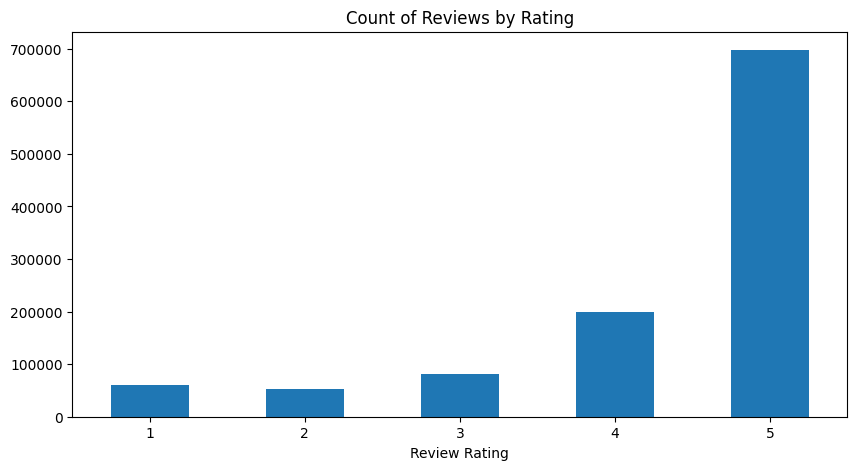

In [104]:
ax = combined_df['rating'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Rating',
          figsize=(10, 5))
ax.set_xlabel('Review Rating')
plt.xticks(rotation=0)
plt.show()

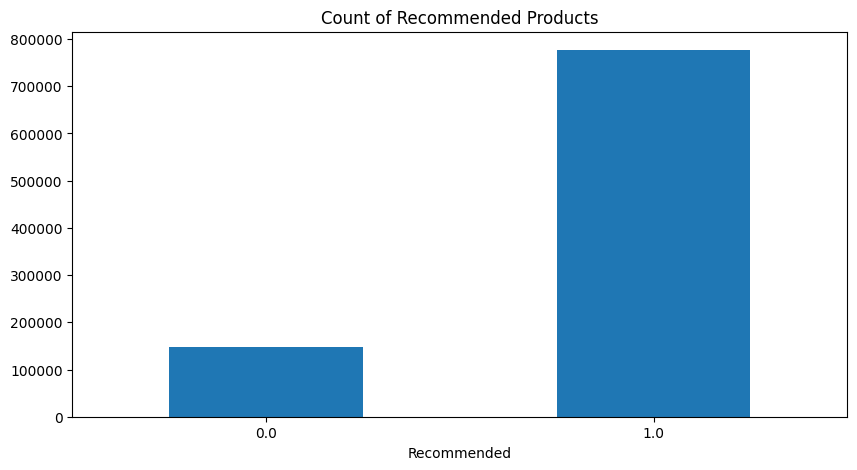

In [105]:
ax = combined_df['is_recommended'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Recommended Products',
          figsize=(10, 5))
ax.set_xlabel('Recommended')
plt.xticks(rotation=0)
plt.show()

## NLP Basics

Example review

In [113]:
example = combined_df['review_text'][1337]
print(example)

this feels amazing and so soft when you first use it. and it smells amazing! but after continued use, it dried out my already dry lips. it seems hydrating, but it tricks you and just dries it out later. so many better lip products like kosas lipfuel


Tokenization

In [115]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [116]:
tokens = nltk.word_tokenize(example)
tokens[:10]

['this',
 'feels',
 'amazing',
 'and',
 'so',
 'soft',
 'when',
 'you',
 'first',
 'use']

POS-Tagging

In [118]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [119]:
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('this', 'DT'),
 ('feels', 'VBZ'),
 ('amazing', 'JJ'),
 ('and', 'CC'),
 ('so', 'RB'),
 ('soft', 'JJ'),
 ('when', 'WRB'),
 ('you', 'PRP'),
 ('first', 'RB'),
 ('use', 'VB')]

In [120]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [123]:
nltk.download('maxent_ne_chunker_tab')

[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker_tab.zip.


True

In [121]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [124]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  this/DT
  feels/VBZ
  amazing/JJ
  and/CC
  so/RB
  soft/JJ
  when/WRB
  you/PRP
  first/RB
  use/VB
  it/PRP
  ./.
  and/CC
  it/PRP
  smells/VBZ
  amazing/JJ
  !/.
  but/CC
  after/IN
  continued/VBN
  use/NN
  ,/,
  it/PRP
  dried/VBD
  out/RP
  my/PRP$
  already/RB
  dry/JJ
  lips/NNS
  ./.
  it/PRP
  seems/VBZ
  hydrating/VBG
  ,/,
  but/CC
  it/PRP
  tricks/VBZ
  you/PRP
  and/CC
  just/RB
  dries/NNS
  it/PRP
  out/RP
  later/RB
  ./.
  so/RB
  many/JJ
  better/JJR
  lip/NN
  products/NNS
  like/IN
  kosas/NNS
  lipfuel/VBP)


## VADER Sentiment Score

### Short Description

Vader (Valence Aware Dictionary and Sentiment Reasoner) is a rule-based sentiment analysis tool that is specifically designed for analyzing social media texts. Vader is a pre-trained sentiment analysis model that provides a sentiment score for a given text.

Vader uses a dictionary of words and rules to determine the sentiment of a piece of text. It uses a valence score for each word to determine its positivity or negativity. The valence score ranges from -4 to +4, with -4 being the most negative and +4 being the most positive.

Uses "bag of words" approach
- Stopwords are removed
- Each word is scored and combined into total score

Some bulletpoints about VADER:
- Lexicon and rule-based model that relies on predefined list of words and meanings
- Uses simple rules to analyze sentiments
- Might misinterpret context 
- It is static, doesn't adapt after initial development
- Performance is based on the dictionary it uses
- Primarily focuses on English
- Requires manual addition of lexicon and rule-set 

Link: https://medium.com/@rslavanyageetha/vader-a-comprehensive-guide-to-sentiment-analysis-in-python-c4f1868b0d2e#:~:text=Vader%20uses%20a%20dictionary%20of,4%20being%20the%20most%20positive.

### Installing Necessities

In [125]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jabbawocka/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [126]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

analyzer = SentimentIntensityAnalyzer()

Simple examples

In [127]:
analyzer.polarity_scores('This is a very good product')

{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.4927}

In [128]:
analyzer.polarity_scores('This is the worst product ever')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.6249}

In [130]:
# Trying with the example from above
print(example)
analyzer.polarity_scores(example)

this feels amazing and so soft when you first use it. and it smells amazing! but after continued use, it dried out my already dry lips. it seems hydrating, but it tricks you and just dries it out later. so many better lip products like kosas lipfuel


{'neg': 0.031, 'neu': 0.745, 'pos': 0.224, 'compound': 0.897}

### Polarity score on the DataFrame

In [132]:
def get_polarity_scores(text):
    return analyzer.polarity_scores(text)

In [133]:
combined_df['polarity_score'] = combined_df['clean_text'].apply(get_polarity_scores)

In [134]:
combined_df.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id,clean_text,polarity_score
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524,i use this with the nudestix citrus clean balm...,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp..."
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263,i bought this lip mask after reading the revie...,"{'neg': 0.079, 'neu': 0.825, 'pos': 0.096, 'co..."
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401,my review title says it all! i get so excited ...,"{'neg': 0.052, 'neu': 0.905, 'pos': 0.042, 'co..."
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851,i’ve always loved this formula for a long time...,"{'neg': 0.0, 'neu': 0.707, 'pos': 0.293, 'comp..."
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835,"if you have dry cracked lips, this is a must h...","{'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compou..."


Separating `polarity_score` column into `neg`, `neu`, `pos` and `compound` for `combined_df`

In [136]:
combined_df['neg'] = combined_df['polarity_score'].apply(lambda x: x['neg'])
combined_df['neu'] = combined_df['polarity_score'].apply(lambda x: x['neu'])
combined_df['pos'] = combined_df['polarity_score'].apply(lambda x: x['pos'])
combined_df['compound'] = combined_df['polarity_score'].apply(lambda x: x['compound'])

combined_df = combined_df.drop('polarity_score', axis=1)

In [137]:
combined_df.head()

,review_id,review_text,product_id,rating,review_title,is_recommended,author_id,clean_text,neg,neu,pos,compound
0,0,I use this with the Nudestix “Citrus Clean Bal...,P504322,5,Taught me how to double cleanse!,1.0,1741593524,i use this with the nudestix citrus clean balm...,0.000,0.806,0.194,0.9392
1,1,I bought this lip mask after reading the revie...,P420652,1,Disappointed,0.0,31423088263,i bought this lip mask after reading the revie...,0.079,0.825,0.096,0.1280
2,2,My review title says it all! I get so excited ...,P420652,5,New Favorite Routine,1.0,5061282401,my review title says it all! i get so excited ...,0.052,0.905,0.042,-0.1240
3,3,I’ve always loved this formula for a long time...,P420652,5,Can't go wrong with any of them,1.0,6083038851,i’ve always loved this formula for a long time...,0.000,0.707,0.293,0.9460
4,4,"If you have dry cracked lips, this is a must h...",P420652,5,A must have !!!,1.0,47056667835,"if you have dry cracked lips, this is a must h...",0.000,0.940,0.060,0.3291


### Plot VADER Results

Looking at Rating vs. VADER Compound Score

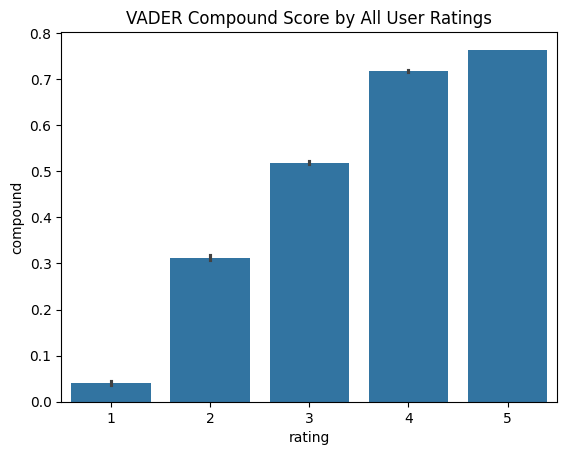

In [138]:
ax = sns.barplot(data=combined_df, x='rating', y='compound')
ax.set_title('VADER Compound Score by All User Ratings')
plt.show()

Looking at individual negative, neutral and positive VADER scores

In [139]:
unique_ratings = combined_df['rating'].nunique()
palette = sns.color_palette("deep", unique_ratings)

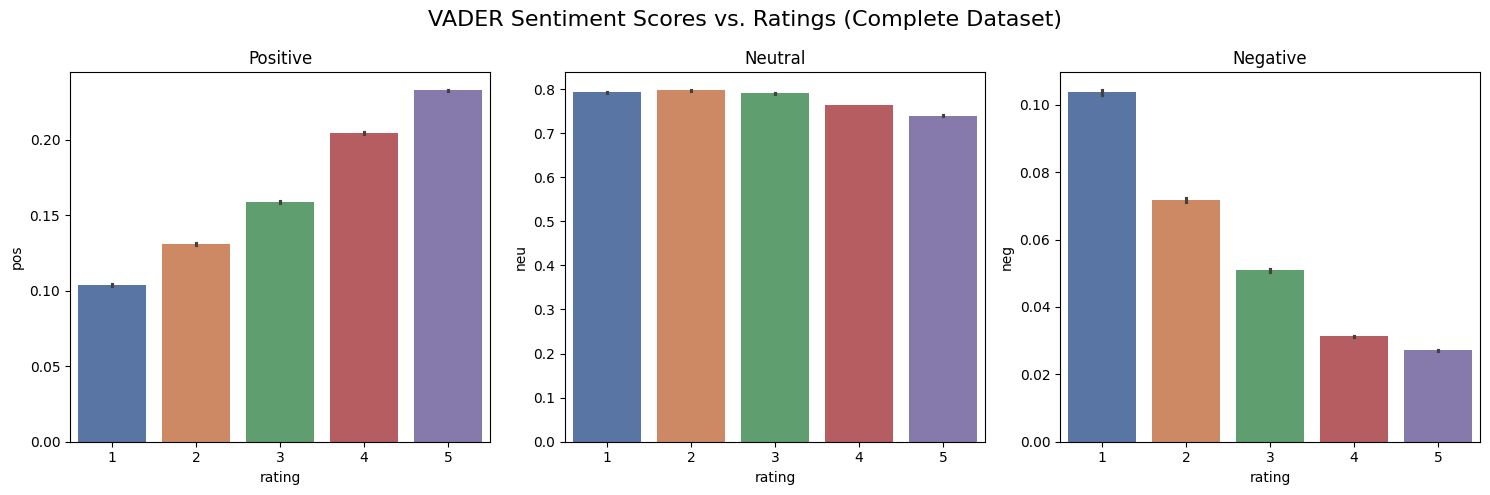

In [140]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=combined_df, x='rating', y='pos', hue='rating', ax=axs[0], palette=palette, legend=False)
sns.barplot(data=combined_df, x='rating', y='neu', hue='rating', ax=axs[1], palette=palette, legend=False)
sns.barplot(data=combined_df, x='rating', y='neg', hue='rating', ax=axs[2], palette=palette, legend=False)
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
fig.suptitle('VADER Sentiment Scores vs. Ratings (Complete Dataset)', fontsize=16)

plt.tight_layout()
plt.show()

## RoBERTa Model

### Brief Description

RoBERTa = Robustly optimized BERT model

Advantages of RoBERTa over VADER:
- It is a deep learning model based on Transformer architecture. It captures context of words in a sentence better.
- Trained on large datasets and learns from context
- Effectively handles change in language usage over time, slang, emerging terms etc. 
- Has versions to support multiple languages
- Can be fine-tuned on specific dataset
- More suitable for applications where the context and depth of language understanding are critical

### Load RoBERTa Model and Tokenizer

In [141]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# pre-trained RoBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

/Users/jabbawocka/Desktop/SPICED/Project/product-recommendation/porefectionist/sentiment-analysis/Deliverables/hope/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### Sentiment Prediction Function

In [147]:
def predict_sentiment(review):
    # max length the model can handle
    max_length = 512
    # Tokenize input text
    inputs = tokenizer(review, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the prediction
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment_score = probs.argmax(dim=1).item()
    
    # Map the score to sentiment labels
    labels = ['Negative', 'Neutral', 'Positive']
    return labels[sentiment_score], probs[0][sentiment_score].item()

# RoBERTa on Batches

I don't trust myself enough to write a loop for batches, so I will manually run the next cell to process them.

In [156]:
import time
import pandas as pd
from tqdm import tqdm  # Import tqdm for live progress

# Function to process each chunk
def process_chunk(chunk):
    errors = []  # List to store any errors encountered during processing
    results = []
    
    chunk = chunk.copy()  # Ensure we are working with a copy to avoid SettingWithCopyWarning

    for index, row in chunk.iterrows():
        try:
            # Attempt to process the row
            sentiment, sentiment_score = predict_sentiment(row['clean_text'])
            results.append((index, sentiment, sentiment_score))
        except Exception as e:
            # If an error occurs, append the error details to the errors list
            errors.append((index, str(e)))  # Log the index and the actual error message

    # If no errors occurred, update the chunk with sentiment results
    if results:
        indices, sentiments, sentiment_scores = zip(*results)
        chunk.loc[indices, 'sentiment'] = sentiments
        chunk.loc[indices, 'sentiment_score'] = sentiment_scores
    
    return chunk, errors

# Initialize variables for tracking time
batch_size = 1024  # Set batch size to 1024
batch_name = sample10k # Set the correct batch name here
total_batches = len(batch_name) // batch_size + (1 if len(batch_name) % batch_size != 0 else 0)
batch_times = []

# Process the dataset in batches with a live progress bar
results = []
all_errors = []  # List to store all errors across batches
start_time = time.time()

# Use tqdm to create a progress bar
for i in tqdm(range(total_batches), desc="Processing Batches", unit="batch"):
    start_batch_time = time.time()
    
    start = i * batch_size
    end = min((i + 1) * batch_size, len(batch_name))
    chunk = batch_name.iloc[start:end].copy()  # Copy to avoid SettingWithCopyWarning
    
    # Process the chunk with error handling
    processed_chunk, errors = process_chunk(chunk)
    results.append(processed_chunk)
    all_errors.extend(errors)
    
    # Track time taken for the batch
    end_batch_time = time.time()
    batch_time = end_batch_time - start_batch_time
    batch_times.append(batch_time)
    
    # Optionally log the time for each batch (not necessary if using tqdm)
    print(f"Processed batch {i + 1}/{total_batches} in {batch_time:.2f} seconds.")
    
# Combine all results
df_with_sentiment = pd.concat(results, ignore_index=True)

# Save the results
df_with_sentiment.to_csv('rev1_with_sentiment.csv', index=False)

# Save the errors to a separate file for review
if all_errors:
    error_df = pd.DataFrame(all_errors, columns=['index', 'error_message'])
    error_df.to_csv('processing_errors.csv', index=False)
    print(f"Errors encountered and saved to processing_errors.csv: {len(all_errors)} rows.")

# Calculate total time
total_time = time.time() - start_time
print(f"Total processing time: {total_time:.2f} seconds.")


Processing Batches:  10%|█         | 1/10 [00:48<07:12, 48.03s/batch]

Processed batch 1/10 in 48.03 seconds.


Processing Batches:  20%|██        | 2/10 [01:30<05:55, 44.49s/batch]

Processed batch 2/10 in 42.02 seconds.


Processing Batches:  30%|███       | 3/10 [02:15<05:15, 45.06s/batch]

Processed batch 3/10 in 45.73 seconds.


Processing Batches:  40%|████      | 4/10 [03:00<04:29, 44.93s/batch]

Processed batch 4/10 in 44.72 seconds.


Processing Batches:  50%|█████     | 5/10 [03:44<03:42, 44.48s/batch]

Processed batch 5/10 in 43.69 seconds.


Processing Batches:  60%|██████    | 6/10 [04:30<03:00, 45.05s/batch]

Processed batch 6/10 in 46.16 seconds.


Processing Batches:  70%|███████   | 7/10 [05:16<02:16, 45.54s/batch]

Processed batch 7/10 in 46.53 seconds.


Processing Batches:  80%|████████  | 8/10 [06:03<01:31, 45.97s/batch]

Processed batch 8/10 in 46.89 seconds.


Processing Batches:  90%|█████████ | 9/10 [06:53<00:47, 47.16s/batch]

Processed batch 9/10 in 49.79 seconds.


Processing Batches: 100%|██████████| 10/10 [07:34<00:00, 45.50s/batch]

Processed batch 10/10 in 41.39 seconds.
Total processing time: 455.07 seconds.


In [159]:
df_with_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        10000 non-null  int64  
 1   review_text      10000 non-null  object 
 2   product_id       10000 non-null  object 
 3   rating           10000 non-null  int64  
 4   review_title     7001 non-null   object 
 5   is_recommended   9559 non-null   float64
 6   author_id        10000 non-null  object 
 7   clean_text       10000 non-null  object 
 8   sentiment        10000 non-null  object 
 9   sentiment_score  10000 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 781.4+ KB


# References

### RoBERTa Resources

- **Original Paper on RoBERTa**
  - [RoBERTa: A Robustly Optimized BERT Pretraining Approach](https://arxiv.org/abs/1907.11692) - Yinhan Liu et al.

- **Hugging Face Models**
  - [Hugging Face - RoBERTa Models](https://huggingface.co/models?search=roberta)

- **BERT and RoBERTa Explained**
  - [The Illustrated BERT and RoBERTa](http://jalammar.github.io/illustrated-bert/)

### VADER Resources

- **Original Paper on VADER**
  - [VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text](https://ojs.aaai.org/index.php/ICWSM/article/view/14550) - C.J. Hutto and Eric Gilbert

- **GitHub Repository**
  - [VADER GitHub](https://github.com/cjhutto/vaderSentiment)

- **Practical Tutorial**
  - [VADER sentiment analysis tutorial on Towards Data Science](https://towardsdatascience.com) (Search for "VADER sentiment analysis" on the site)

### Additional Learning Resources

- **Books on NLP**
  - "Natural Language Processing with Python" by Steven Bird, Ewan Klein, and Edward Loper

- **Online Courses**
  - [Coursera - Natural Language Processing](https://www.coursera.org)
  - [edX - Deep Learning Specialization](https://www.edx.org)
